# 5 filtri e redshift
Rete neurale che prende in input i 5 filtri (u, g, r, i, z) ed il redshift, con learning rate che diminuisce durante l'allenamento, early stopping, dropout, Adam come optimizer, Relu come funzione di attivazione

In [1]:
import pandas as pd
# Leggo il DataFrame rielaborato
input_file = 'dataset_rielaborato_filtrato.csv'
df = pd.read_csv(input_file)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Parametri da modificare
N_epoche = 90
N_batch_size = 64
N_train_split = 0.8           # Il ...% dei dati sono di train
N_validation_split = 0.2      # Il ...% dei dati di train sono di validation
Learning_rate = 0.001
My_dropout = 0.1

# Dati di train e test
train_dataset = df.sample(frac=N_train_split, random_state=1)   # Sceglie casualmente (seme = 1 per riproducibilità) dal dataframe le righe per i dati di train 
test_dataset = df.drop(train_dataset.index)                     # Elimina dal dataframe le righe dei dati di train e pone le altre ai dati di test

# Features (input) e targets (output)
X_train = train_dataset[['u', 'g', 'r', 'i', 'z', 'redshift']]                 # Train input
Y_train = train_dataset[['label_STAR', 'label_GALAXY', 'label_QSO']]           # Train output (target per classificazione)
X_test = test_dataset[['u', 'g', 'r', 'i', 'z', 'redshift']]                   # Test input
Y_test = test_dataset[['label_STAR', 'label_GALAXY', 'label_QSO']]             # Test output (target per classificazione)

# Definizione del modello
model = Sequential()

# Strati della rete
model.add(Dense(128, input_shape=(6,), activation='relu'))  # 128 unità e funzione di attivazione ReLU
model.add(Dropout(My_dropout))
model.add(Dense(64, activation='relu'))                     # 64 unità e funzione di attivazione ReLU
model.add(Dropout(My_dropout))
model.add(Dense(3, activation='softmax'))                   # Softmax per classificazione multi-classe (3 classi: STAR, GALAXY, QSO)

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=Learning_rate),  # Ottimizzatore Adam
              loss='categorical_crossentropy',              # Funzione di perdita per classificazione multi-classe
              metrics=['accuracy'])                         # Metriche di valutazione (accuratezza)

print('--------------------------------------------------------------------------------------------------------------------------------')
print("Riepilogo della struttura del modello:")
model.summary()
print('--------------------------------------------------------------------------------------------------------------------------------')

# Callback per ridurre il learning rate automaticamente
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitora la 'val_loss'
                              factor=0.5,          # Riduce il learning rate della metà (factor)
                              patience=5,          # Numero di epoche senza miglioramento prima della riduzione
                              min_lr=1e-6,         # Learning rate minimo
                              verbose=1)           # Output dettagliato sulla riduzione del learning rate

# Callback personalizzata per stampare solo alcune epoche
class StampaEpochePersonalizzata(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:  # Stampa solo per epoche multiple di 5
            print(f'Epoca {epoch + 1}: Accuracy={logs["accuracy"]}, Loss={logs["loss"]} ----- Validation Accuracy={logs["val_accuracy"]}, Validation Loss={logs["val_loss"]}')

# Compilazione del modello con Adam come ottimizzatore
model.compile(optimizer=Adam(learning_rate=Learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Addestramento del modello con ReduceLROnPlateau e early stopping come callback 
history = model.fit(X_train, Y_train,
                    epochs=N_epoche,
                    batch_size=N_batch_size,
                    validation_split=N_validation_split,
                    verbose=0,
                    callbacks=[reduce_lr, StampaEpochePersonalizzata(), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

# Valutazione del modello sui dati di test
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print('--------------------------------------------------------------------------------------------------------------------------------')
print('Valutazione del modello sui dati di test:')
print(f'Loss su test: {test_loss}')
print(f'Accuratezza su test: {test_accuracy}')
print('--------------------------------------------------------------------------------------------------------------------------------')


--------------------------------------------------------------------------------------------------------------------------------
Riepilogo della struttura del modello:


C:\Users\alban\anaconda3\envs\tff\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,347 (36.51 KB)

 Trainable params: 9,347 (36.51 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------------------------------------------------------------------------------------
Epoca 3: Accuracy=0.9373115301132202, Loss=0.18407610058784485 ----- Validation Accuracy=0.9482499957084656, Validation Loss=0.16030676662921906
Epoca 6: Accuracy=0.9479835629463196, Loss=0.16020920872688293 ----- Validation Accuracy=0.9308124780654907, Validation Loss=0.18756650388240814
Epoca 9: Accuracy=0.954608678817749, Loss=0.14363572001457214 ----- Validation Accuracy=0.9552500247955322, Validation Loss=0.1304575353860855
Epoca 12: Accuracy=0.9569993019104004, Loss=0.13778123259544373 ----- Validation Accuracy=0.9583749771118164, Validation Loss=0.12949328124523163
Epoca 15: Accuracy=0.9570930600166321, Loss=0.1372738778591156 ----- Validation Accuracy=0.9585000276565552, Validation Loss=0.1285221129655838
Epoca 18: Accuracy=0.9545461535453796, Loss=0.1418127566576004 ----- Validation Accuracy=0.9588750004768372, Validation Loss=0.12410799413919449
Epo

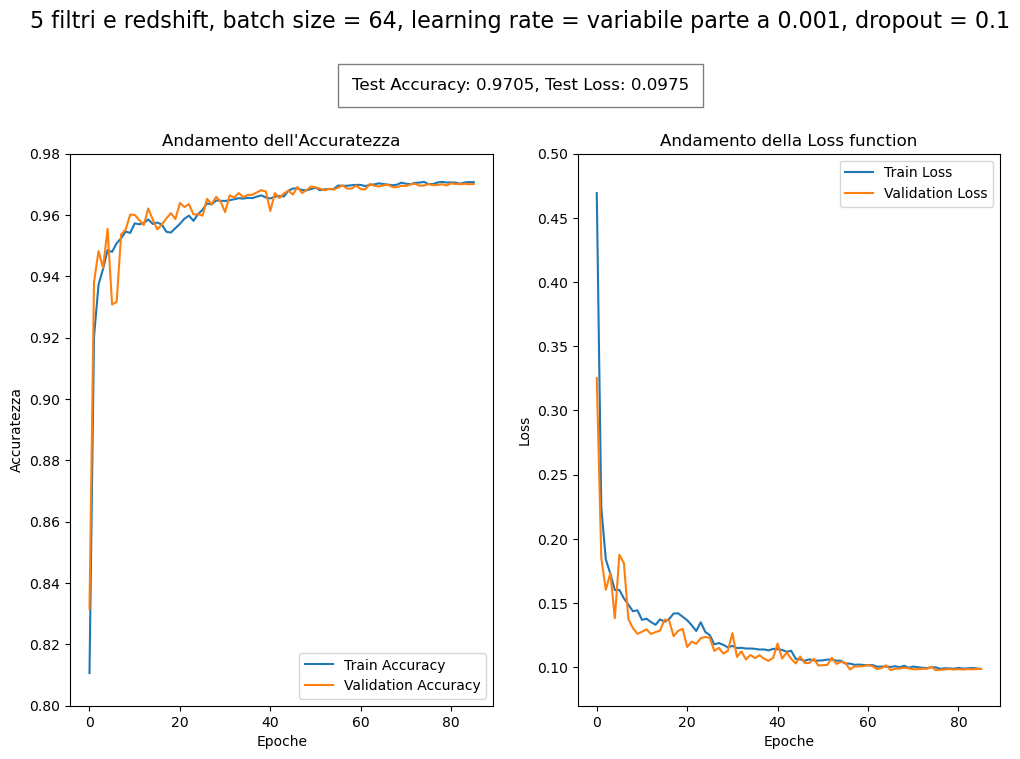

In [3]:
# Grafico dell'andamento dell'accuratezza e della loss durante l'addestramento
plt.figure(figsize=(12, 8))

# Titolo grande sopra tutti i sottoplot
plt.suptitle(f'5 filtri e redshift, batch size = {N_batch_size}, learning rate = variabile parte a 0.001, dropout = {My_dropout}', fontsize=16)

# Riquadri per i valori della Loss e accuracy sui dati di test
plt.figtext(0.5, 0.88, f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}', ha='center', fontsize=12, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# Grafico dell'accuratezza
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Andamento dell\'Accuratezza')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.ylim(0.80, 0.98)  # Limita l'asse y tra 0.80 e 0.98
plt.legend()

# Grafico della loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Andamento della Loss function')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.ylim(0.07, 0.50)  # Limita l'asse y tra 0.10 e 0.50
plt.legend()

# Aggiungo spazio tra il riquadro e i grafici
plt.subplots_adjust(top=0.8) 

# Salvo l'immagine
plt.savefig('./Immagini/LR_variabileA_BATCH_64_dropout.png')

plt.show()

# Analisi dei risultati

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


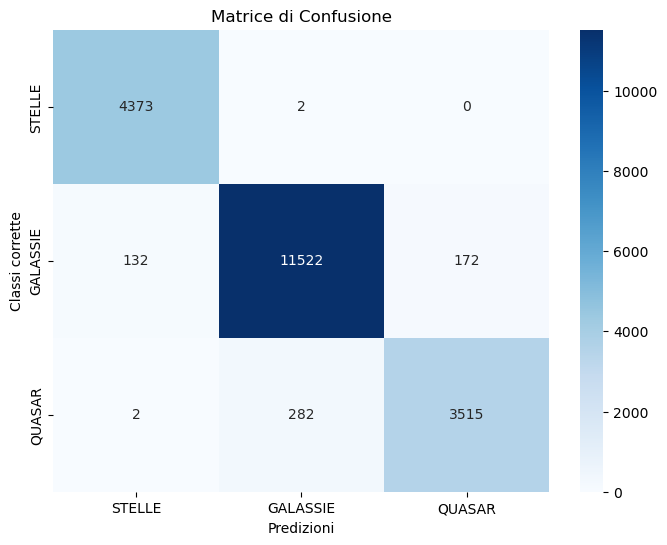

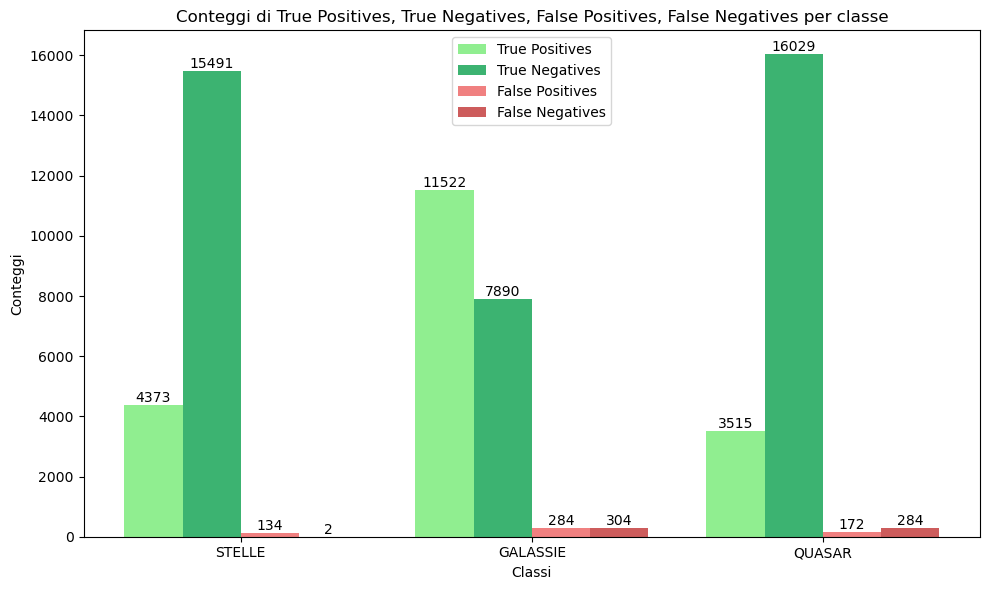

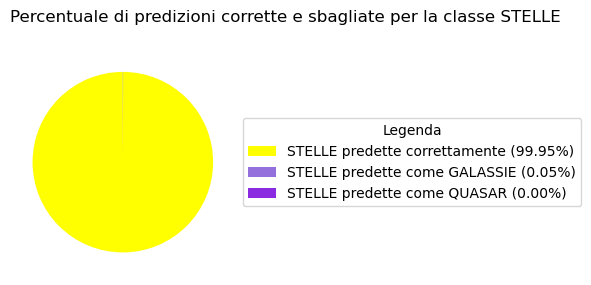

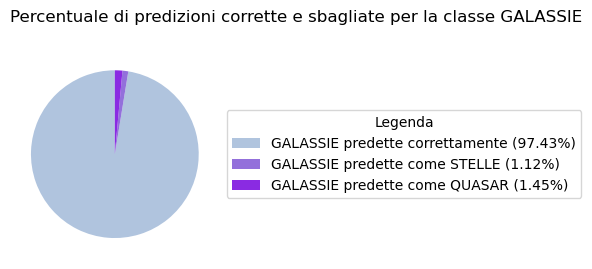

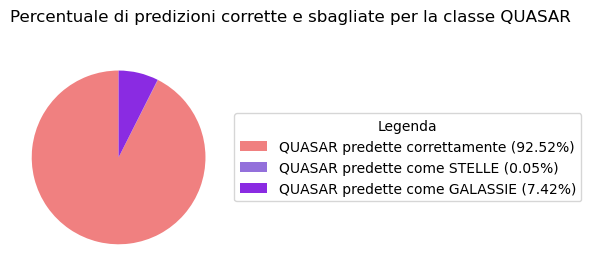

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt  # Import necessario per i plot
from sklearn.metrics import confusion_matrix
import numpy as np

colori = {
    'STELLE': 'yellow',
    'GALASSIE': 'lightsteelblue',
    'QUASAR': 'lightcoral'
}
# Classi
classi = ['STELLE', 'GALASSIE', 'QUASAR']

# PREDIZIONE E MATRICE DI CONFUSIONE ------------------------------------------------------------------------------------------------------------------------
# Predizioni sui dati di test
Y_test_pred = model.predict(X_test)
Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)  # Ottieni le classi predette
Y_test_true_classes = np.argmax(Y_test, axis=1)  # Ottieni le classi vere (da one-hot a classi)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test_true_classes, Y_test_pred_classes)

# Creazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classi, yticklabels=classi)

plt.title('Matrice di Confusione')
plt.xlabel('Predizioni')
plt.ylabel('Classi corrette')
plt.savefig('./Immagini/Confusion_matrix_drop.png')
plt.show()

# GRAFICO A BARRE-------------------------------------------------------------------------------------------------------------------------------
# Calcolo di TP, TN, FP, FN per ciascuna classe
TP = np.diag(conf_matrix)  # True Positives sono sulla diagonale
FP = conf_matrix.sum(axis=0) - TP         # False Positives: somma su colonna meno i TP
FN = conf_matrix.sum(axis=1) - TP         # False Negatives: somma su riga meno i TP
TN = conf_matrix.sum() - (FP + FN + TP)   # True Negatives: tutto il resto

# Grafico a barre per TP, TN, FP, FN
labels = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']
bar_width = 0.2
index = np.arange(len(classi))

plt.figure(figsize=(10, 6))

# Plotto i valori per ciascuna classe con colori personalizzati
bars1 = plt.bar(index, TP, bar_width, label='True Positives', color='lightgreen')  # Verde chiaro
bars2 = plt.bar(index + bar_width, TN, bar_width, label='True Negatives', color='mediumseagreen')  # Verde medio
bars3 = plt.bar(index + 2 * bar_width, FP, bar_width, label='False Positives', color='lightcoral')  # Rosso chiaro
bars4 = plt.bar(index + 3 * bar_width, FN, bar_width, label='False Negatives', color='indianred')  # Rosso medio

# Aggiungo i numeri sopra ogni barra
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Aggiusto le etichette e il layout
plt.xlabel('Classi')
plt.ylabel('Conteggi')
plt.title('Conteggi di True Positives, True Negatives, False Positives, False Negatives per classe')
plt.xticks(index + 1.5 * bar_width, classi)
plt.legend()

plt.tight_layout()
plt.savefig('./Immagini/TPTNFPFN_drop.png')
plt.show()

# GRAFICI A TORTA-----------------------------------------------------------------------------------------------------------------------
for i, classe in enumerate(classi):
    true_class_total = conf_matrix[i].sum()  # Totale di questa classe reale (righe)
    correct_predictions = TP[i]                                                         # True Positives per questa classe
    wrong_as_other_classes = [conf_matrix[i, j] for j in range(len(classi)) if i != j]  # Predetti come altre classi
    
    # Percentuali per il grafico a torta
    percentages = [correct_predictions / true_class_total * 100] + [wrong / true_class_total * 100 for wrong in wrong_as_other_classes]

    # Etichette con le percentuali per la legenda
    labels = [f'{classe} predette correttamente ({percentages[0]:.2f}%)']
    p = 1
    for j in range(len(classi)):
        if i != j:                                                                      # Controllo se la classe non è quella corretta
            labels.append(f'{classe} predette come {classi[j]} ({percentages[p]:.2f}%)')
            p += 1

    # Creazione del grafico a torta
    plt.figure(figsize=(6, 6))
    wedges, texts = plt.pie(percentages, startangle=90, colors=[colori[classi[i]], 'mediumpurple', 'blueviolet'])
    
    # Aggiunta della legenda di fianco al grafico con percentuali
    plt.legend(wedges, labels, title="Legenda", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Titolo del grafico
    plt.title(f'Percentuale di predizioni corrette e sbagliate per la classe {classe}', loc='left', pad=20)
    plt.tight_layout()
    plt.savefig(f'./Immagini/Torta_{classe}_drop.png')
    plt.show()

# ROC curves

Asse Y: tasso di veri positivi (True Positive Rate o Sensitivity):
$$ TPR = \frac{TP}{TP+FN}$$
 
Asse X: Tasso di falsi positivi (False Positive Rate), che rappresenta la proporzione di negativi che sono stati erroneamente identificati come positivi:
$$ FPR = \frac{FP}{FP+TN}$$


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


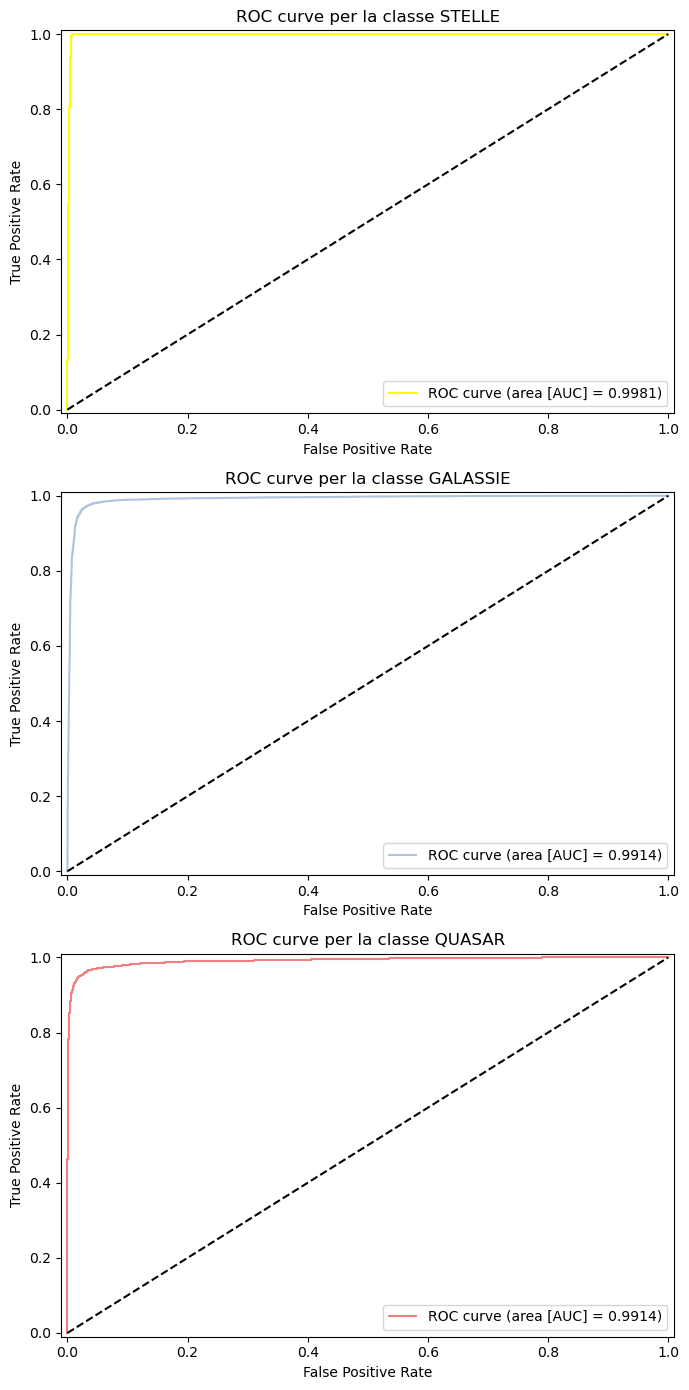

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarizzazione dei target (porto in formato binario per facilitare ROC curve)
Y_train_bin = Y_train.values 
Y_test_bin = Y_test.values

# Calcolo delle predizioni
Y_test_pred = model.predict(X_test)

# Calcolo delle ROC curve e AUC per ciascuna classe
n_classes = 3
y_test_bin = label_binarize(Y_test.values.argmax(axis=1), classes=[0, 1, 2])  # Binarizza le etichette
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], Y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Grafico delle ROC curve
plt.figure(figsize=(7, 14))

for i in range(n_classes):
    plt.subplot(3, 1, i + 1)
    plt.plot(fpr[i], tpr[i], label='ROC curve (area [AUC] = {:.4f})'.format(roc_auc[i]), color=colori[classi[i]]) 
    plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve per la classe {classi[i]}')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f'./Immagini/ROC_drop.png')
plt.show()